In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [55]:
# ----------------------------------------------------------------------------
# 1. ENVIRONMENT DEFINITION
# ----------------------------------------------------------------------------

class AdPlatform:
    """
    Simulates the ad platform environment.

    This class represents the 'multi-armed bandit' itself. It initializes a set
    of 10 ads (arms), each with a true, hidden average reward. When an ad is
    'shown' (i.e., an arm is pulled), it returns a noisy reward sampled from
    a Gaussian distribution.

    Attributes:
        num_ads (int): The number of ads (arms) in the environment.
        true_rewards (np.array): The hidden average reward for each ad.
        best_ad (int): The index of the ad with the highest true average reward.
    """

    def __init__(self, num_ads=10):
        """
        Initializes the ad platform with a specified number of ads.
        """
        self.num_ads = num_ads
        # Generate true mean rewards from a standard normal distribution
        self.true_rewards = np.random.randn(self.num_ads)
        self.best_ad = np.argmax(self.true_rewards)

    def get_reward(self, ad_index):
        """
        Simulates showing an ad and getting a user engagement reward.

        Args:
            ad_index (int): The index of the ad to show.

        Returns:
            float: A noisy reward from a Gaussian distribution with the true
                   mean for the selected ad and a variance of 1.
        """
        # The reward is the true mean + random noise from a standard normal distribution
        return self.true_rewards[ad_index] + np.random.randn()



In [56]:
# ----------------------------------------------------------------------------
# 2. BANDIT ALGORITHM IMPLEMENTATIONS (SOLVERS)
# ----------------------------------------------------------------------------

class BanditSolver:
    """
    Base class for a multi-armed bandit solving agent.

    Attributes:
        env (AdPlatform): The ad platform environment.
        num_ads (int): Number of ads.
        Q (np.array): Estimated value for each ad.
        N (np.array): Number of times each ad has been selected.
        t (int): The current time step.
    """

    def __init__(self, bandit_env):
        self.env = bandit_env
        self.num_ads = bandit_env.num_ads
        self.Q = np.zeros(self.num_ads)
        self.N = np.zeros(self.num_ads)
        self.t = 0  # Time step counter

    def choose_action(self):
        """Must be implemented by subclasses."""
        raise NotImplementedError

    def update_estimates(self, action, reward):
        """
        Updates the Q-value estimate for the chosen action using an
        incremental sample-average method.
        """
        self.N[action] += 1
        # Incremental update rule: Q_new = Q_old + (1/N) * (Reward - Q_old)
        self.Q[action] += (1 / self.N[action]) * (reward - self.Q[action])
        self.t += 1

    def run_one_step(self):
        """Performs one step of action selection, reward observation, and estimate update."""
        action = self.choose_action()
        reward = self.env.get_reward(action)
        self.update_estimates(action, reward)

        is_optimal = (action == self.env.best_ad)
        return reward, is_optimal

In [57]:
class EpsilonGreedy(BanditSolver):
    """
    e-Greedy algorithm.
    Explores with probability epsilon, otherwise exploits the best-known action.
    """

    def __init__(self, bandit_env, epsilon):
        super().__init__(bandit_env)
        if not (0 <= epsilon <= 1):
            raise ValueError("Epsilon must be between 0 and 1.")
        self.epsilon = epsilon
        self.name = f"e-greedy (e={epsilon})"

    def choose_action(self):
        # Explore: choose a random ad with probability epsilon
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_ads)
        else:
            # Exploit: choose the ad with the highest current Q-value
            return np.argmax(self.Q)


In [ ]:
class DecayingEpsilonGreedy(BanditSolver):
    """
    e-Greedy algorithm with a decaying epsilon value.
    The epsilon decays in a stepwise fashion as specified by the assignment.
    """

    def __init__(self, bandit_env):
        super().__init__(bandit_env)
        self.name = "Decaying e-greedy"

    def choose_action(self):
        # Epsilon decays according to the rule: 1 / (floor(t/50) + 1)
        # t is the current time step (self.t)
        epsilon = 1 / (np.floor(self.t / 50) + 1) if self.t > 0 else 1.0
        # Explore: choose a random ad
        if np.random.rand() < epsilon:
            return np.random.randint(self.num_ads)
        else:
            # Exploit
            return np.argmax(self.Q)


In [ ]:
class UCB(BanditSolver):
    """
    Upper Confidence Bound (UCB1) algorithm.
    Selects actions based on an optimistic estimate of their potential.
    """

    def __init__(self, bandit_env, c):
        super().__init__(bandit_env)
        if c < 0:
            raise ValueError("Exploration parameter c must be non-negative.")
        self.c = c
        self.name = f"UCB (c={c})"

    def choose_action(self):
        # First, play each ad once to initialize estimates
        untried_ads = np.where(self.N == 0)[0]
        if len(untried_ads) > 0:
            return untried_ads[0]

        # Calculate UCB scores for all ads
        # UCB = Q(a) + c * sqrt(log(t) / N(a))
        ucb_values = self.Q + self.c * np.sqrt(np.log(self.t) / self.N)
        return np.argmax(ucb_values)

In [60]:
# ----------------------------------------------------------------------------
# 3. SIMULATION AND PLOTTING FRAMEWORK
# ----------------------------------------------------------------------------

def run_experiment(solver_classes, num_runs, num_steps):
    """
    Runs the full multi-armed bandit simulation.

    Args:
        solver_classes (dict): A dictionary mapping solver names to their
                               class and parameters.
        num_runs (int): The number of independent runs for averaging.
        num_steps (int): The number of time steps per run.

    Returns:
        dict: A dictionary containing the averaged results (rewards and
              optimal selections) for each solver.
    """
    results = {
        name: {'avg_rewards': np.zeros(num_steps), 'pct_optimal': np.zeros(num_steps)}
        for name in solver_classes
    }

    for i in range(num_runs):
        if (i + 1) % 100 == 0:
            print(f"Running simulation: Run {i + 1}/{num_runs}...")

        # For each run, create a new environment and new solver instances
        env = AdPlatform()
        solvers = {
            name: cls(env, **params) for name, (cls, params) in solver_classes.items()
        }

        for step in range(num_steps):
            for name, solver in solvers.items():
                reward, is_optimal = solver.run_one_step()
                results[name]['avg_rewards'][step] += reward
                results[name]['pct_optimal'][step] += 1 if is_optimal else 0

    # Average the results over all runs
    for name in solver_classes:
        results[name]['avg_rewards'] /= num_runs
        results[name]['pct_optimal'] = (results[name]['pct_optimal'] / num_runs) * 100

    print("Simulation complete.")
    return results


In [61]:
def plot_results(results):
    """
    Generates and saves separate plots for each solver (5 parts of the assignment).
    Each solver gets:
      1. Average Engagement Reward vs. Time
      2. Percentage of Optimal Ad Selections vs. Time
    """
    for name, data in results.items():
        safe_name = name.replace(" ", "_").replace("(", "").replace(")", "").replace("=", "")

        # Plot 1: Average Engagement Reward vs. Time
        plt.figure(figsize=(10, 6))
        plt.plot(data['avg_rewards'], label=name, color='blue')
        plt.title(f'Average Engagement Reward vs. Time\n{name}', fontsize=14)
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('Average Reward', fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        filename_reward = f'avg_reward_{safe_name}.png'
        plt.savefig(filename_reward)
        plt.show()
        plt.close()
        print(f"Saved '{filename_reward}'")

        # Plot 2: Percentage of Optimal Ad Selections vs. Time
        plt.figure(figsize=(10, 6))
        plt.plot(data['pct_optimal'], label=name, color='green')
        plt.title(f'Percentage of Optimal Ad Selections vs. Time\n{name}', fontsize=14)
        plt.xlabel('Time Steps', fontsize=12)
        plt.ylabel('% Optimal Ad Selected', fontsize=12)
        plt.ylim(0, 100)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        filename_optimal = f'optimal_selection_{safe_name}.png'
        plt.savefig(filename_optimal)
        plt.show()
        plt.close()
        print(f"Saved '{filename_optimal}'")


Running simulation: Run 100/2000...
Running simulation: Run 200/2000...
Running simulation: Run 300/2000...
Running simulation: Run 400/2000...
Running simulation: Run 500/2000...
Running simulation: Run 600/2000...
Running simulation: Run 700/2000...
Running simulation: Run 800/2000...
Running simulation: Run 900/2000...
Running simulation: Run 1000/2000...
Running simulation: Run 1100/2000...
Running simulation: Run 1200/2000...
Running simulation: Run 1300/2000...
Running simulation: Run 1400/2000...
Running simulation: Run 1500/2000...
Running simulation: Run 1600/2000...
Running simulation: Run 1700/2000...
Running simulation: Run 1800/2000...
Running simulation: Run 1900/2000...
Running simulation: Run 2000/2000...
Simulation complete.


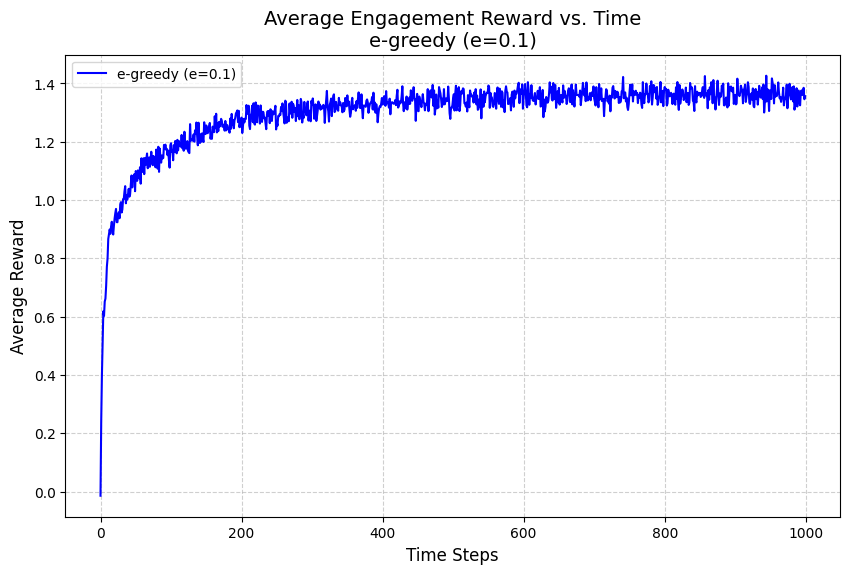

Saved 'avg_reward_e-greedy_e0.1.png'


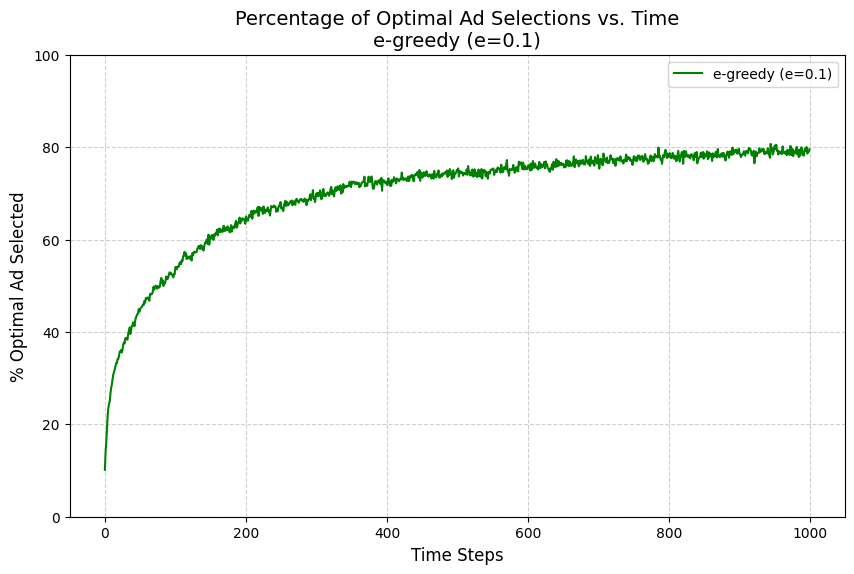

Saved 'optimal_selection_e-greedy_e0.1.png'


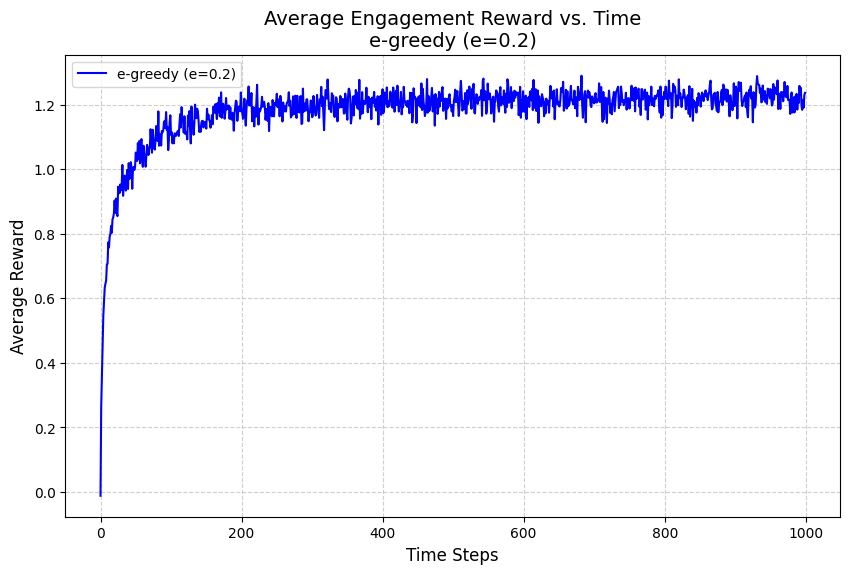

Saved 'avg_reward_e-greedy_e0.2.png'


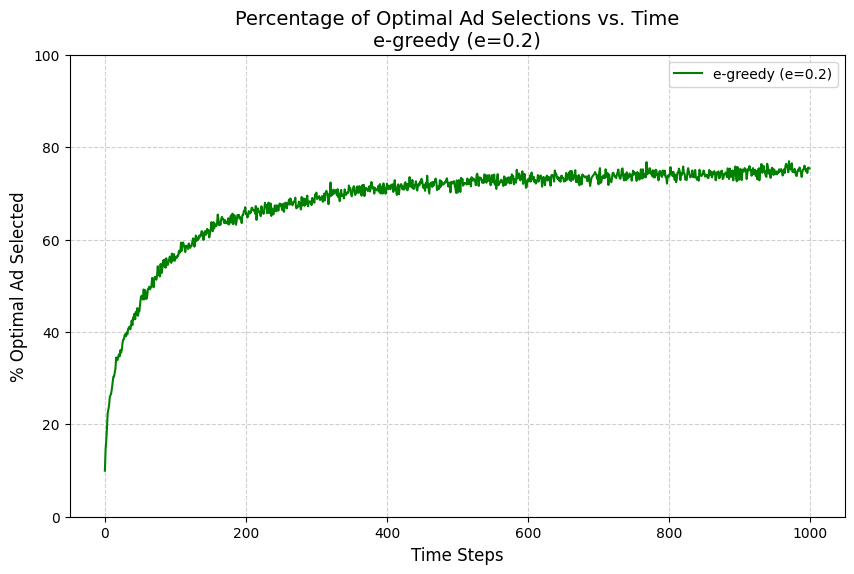

Saved 'optimal_selection_e-greedy_e0.2.png'


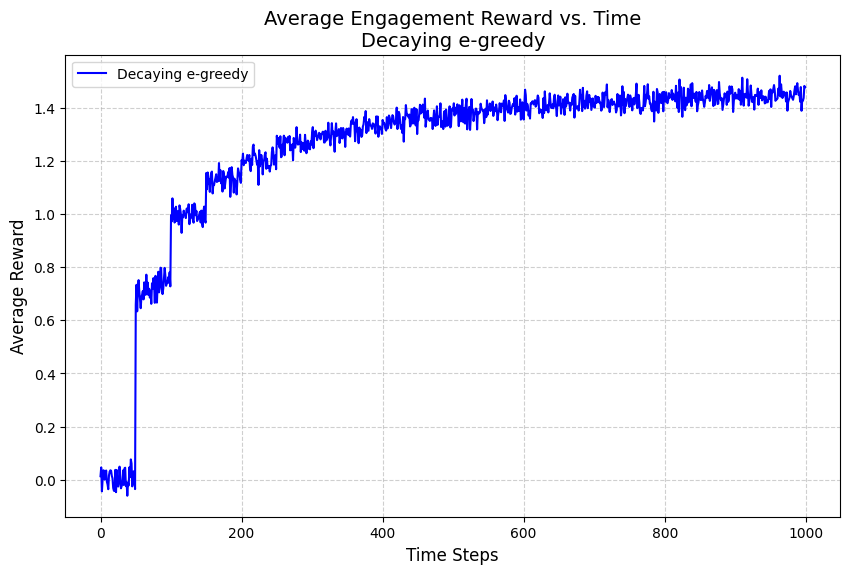

Saved 'avg_reward_Decaying_e-greedy.png'


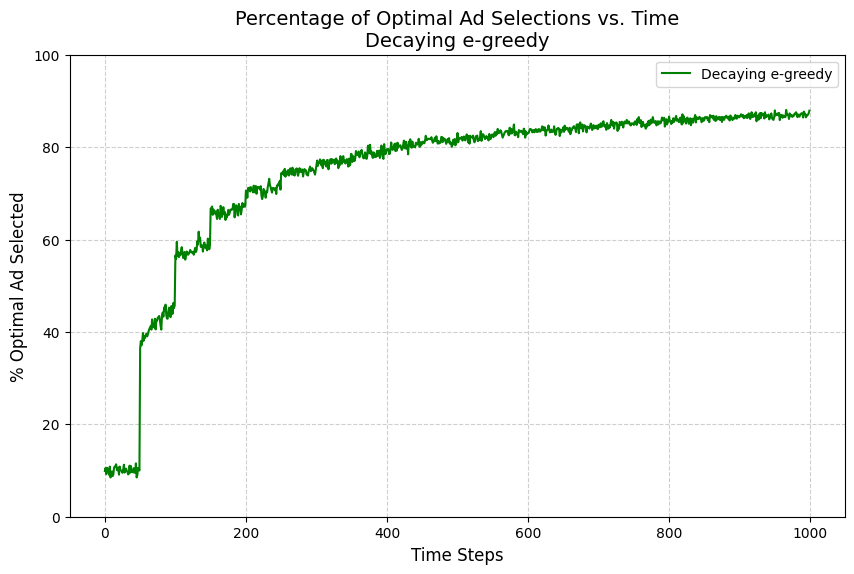

Saved 'optimal_selection_Decaying_e-greedy.png'


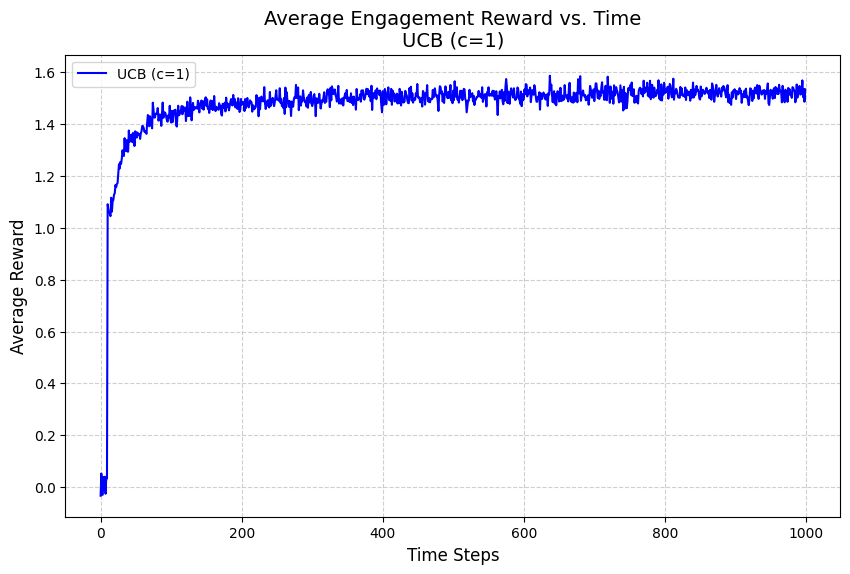

Saved 'avg_reward_UCB_c1.png'


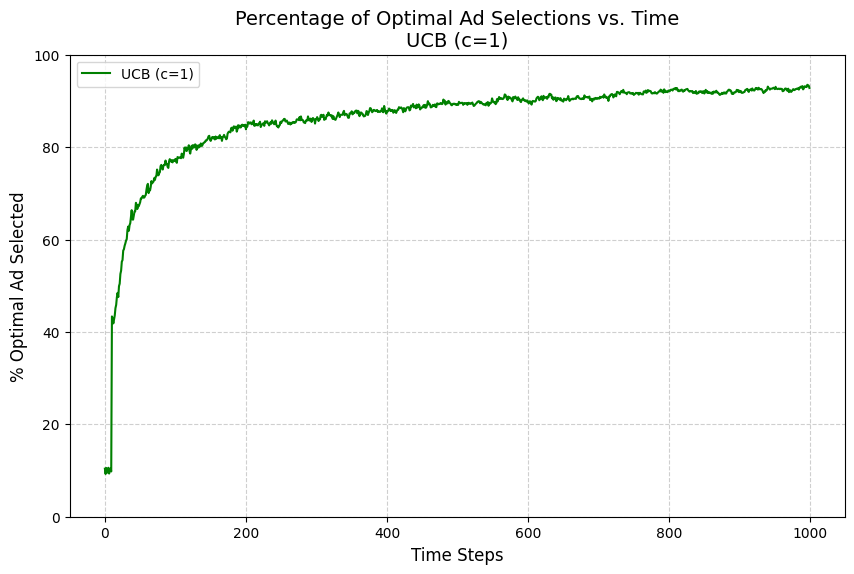

Saved 'optimal_selection_UCB_c1.png'


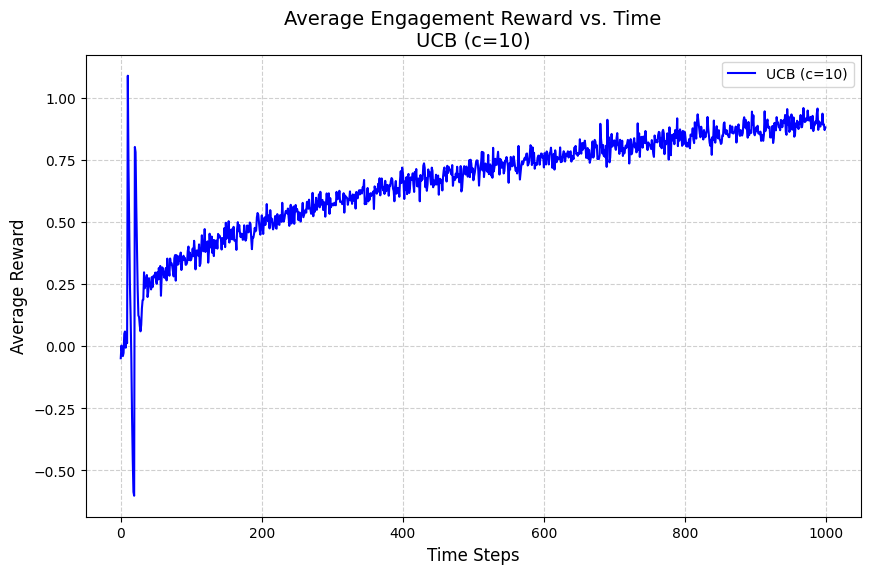

Saved 'avg_reward_UCB_c10.png'


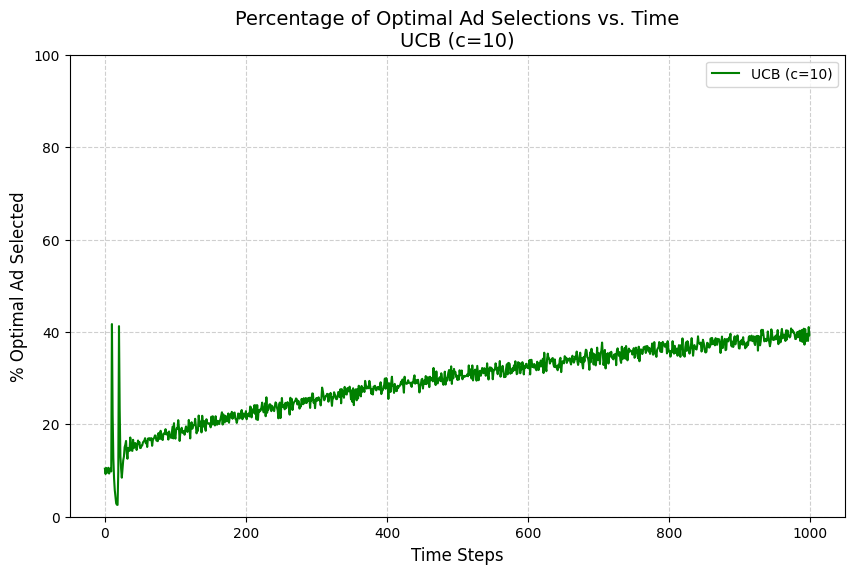

Saved 'optimal_selection_UCB_c10.png'


In [62]:
# ----------------------------------------------------------------------------
# 4. MAIN EXECUTION BLOCK
# ----------------------------------------------------------------------------

if __name__ == '__main__':
    # --- Simulation Parameters ---
    NUM_RUNS = 2000  # As specified in the assignment [cite: 14]
    NUM_STEPS = 1000  # Number of ad selections per run

    # --- Strategies to Compare ---
    # Defines the algorithms and their parameters as per the assignment [cite: 16, 17, 19, 20, 21]
    SOLVER_CONFIG = {
        "e-greedy (e=0.1)": (EpsilonGreedy, {"epsilon": 0.1}),
        "e-greedy (e=0.2)": (EpsilonGreedy, {"epsilon": 0.2}),
        "Decaying e-greedy": (DecayingEpsilonGreedy, {}),
        "UCB (c=1)": (UCB, {"c": 1}),
        "UCB (c=10)": (UCB, {"c": 10})
    }

    # --- Run the simulation ---
    experiment_results = run_experiment(SOLVER_CONFIG, NUM_RUNS, NUM_STEPS)

    # --- Plot the results ---
    plot_results(experiment_results)